# Objetivos
- Reducir falsos positivos en perfiles con transacciones complejas
- Evitar alertas innecesarias en clientes con comportamiento legítimo pero no convencional.
- nueva varibale.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
df = pd.read_csv("feature_engineering_work/dataset_feature_engineering.csv")
df

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,...,False,77.032467,12,3,23,2020,6,3,1,1
1852390,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,...,False,100.023736,12,3,23,2020,5,3,1,1
1852391,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,...,False,80.887812,12,3,23,2020,10,7,1,2
1852392,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,...,False,53.060882,12,3,23,2020,4,2,2,1


In [3]:
# ==============================
# FILTRADO POR RANGO DE FECHAS
# ==============================

# Filtrar datos entre diciembre 2019 y noviembre 2020
df = df[((df["year"] == 2019) & (df["trans_month"] == 12)) | 
        ((df["year"] == 2020) & (df["trans_month"] < 12))]


In [4]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,...,count_month_shopping_net,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
count,9.290660e+05,929066.000000,929066.000000,929066.000000,929066.000000,9.290660e+05,9.290660e+05,929066.000000,929066.000000,929066.000000,...,929066.000000,929066.000000,929066.000000,929066.000000,929066.000000,929066.000000,929066.000000,929066.000000,929066.000000,929066.000000
mean,4.182550e+17,70.086975,48821.536248,38.539820,-90.229667,8.841020e+04,1.369663e+09,38.539478,-90.229723,0.005129,...,4.600631,76.082525,7.162502,2.859118,12.810602,2019.848170,5.296871,3.153359,1.389824,1.659111
std,1.310284e+18,157.832102,26866.539467,5.070742,13.737142,3.004925e+05,9.374002e+06,5.104926,13.749626,0.071432,...,4.617211,29.101663,3.422404,2.210070,6.814587,0.358856,3.092871,1.868512,0.673440,0.904903
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.354320e+09,19.027422,-166.671575,0.000000,...,0.000000,0.124180,1.000000,0.000000,0.000000,2019.000000,1.000000,1.000000,1.000000,1.000000
25%,1.800429e+14,9.640000,26237.000000,34.668900,-96.798000,7.410000e+02,1.361628e+09,34.737191,-96.895471,0.000000,...,1.000000,55.318647,4.000000,1.000000,7.000000,2020.000000,3.000000,2.000000,1.000000,1.000000
50%,3.521417e+15,47.510000,48174.000000,39.354300,-87.476900,2.435000e+03,1.370289e+09,39.369233,-87.444824,0.000000,...,3.000000,78.226336,7.000000,3.000000,14.000000,2020.000000,5.000000,3.000000,1.000000,1.000000
75%,4.642255e+15,83.190000,72042.000000,41.940400,-80.175200,1.968500e+04,1.377370e+09,41.957822,-80.257206,0.000000,...,7.000000,98.436670,10.000000,5.000000,19.000000,2020.000000,7.000000,4.000000,2.000000,2.000000
max,4.992346e+18,28948.900000,99783.000000,65.689900,-67.950300,2.906700e+06,1.385856e+09,66.682905,-66.950902,1.000000,...,42.000000,151.868200,12.000000,6.000000,23.000000,2020.000000,28.000000,17.000000,9.000000,9.000000


In [5]:
df.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud',
       'amt_month', 'amt_year', 'amt_month_shopping_net_spend',
       'count_month_shopping_net', 'first_time_at_merchant',
       'dist_between_client_and_merch', 'trans_month', 'trans_day', 'hour',
       'year', 'times_shopped_at_merchant', 'times_shopped_at_merchant_year',
       'times_shopped_at_merchant_month', 'times_shopped_at_merchant_day'],
      dtype='object')

Distribución de fraudes:
is_fraud
0    0.994871
1    0.005129
Name: proportion, dtype: float64


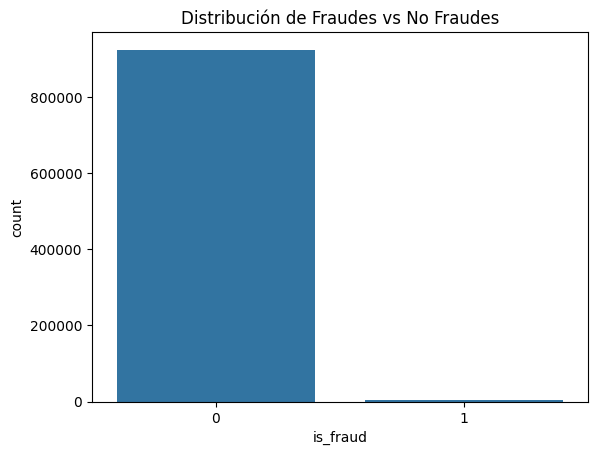

In [7]:
# Distribución
fraud_ratio = df['is_fraud'].value_counts(normalize=True)
print("Distribución de fraudes:")
print(fraud_ratio)

sns.countplot(x='is_fraud', data=df)
plt.title('Distribución de Fraudes vs No Fraudes')
plt.show()


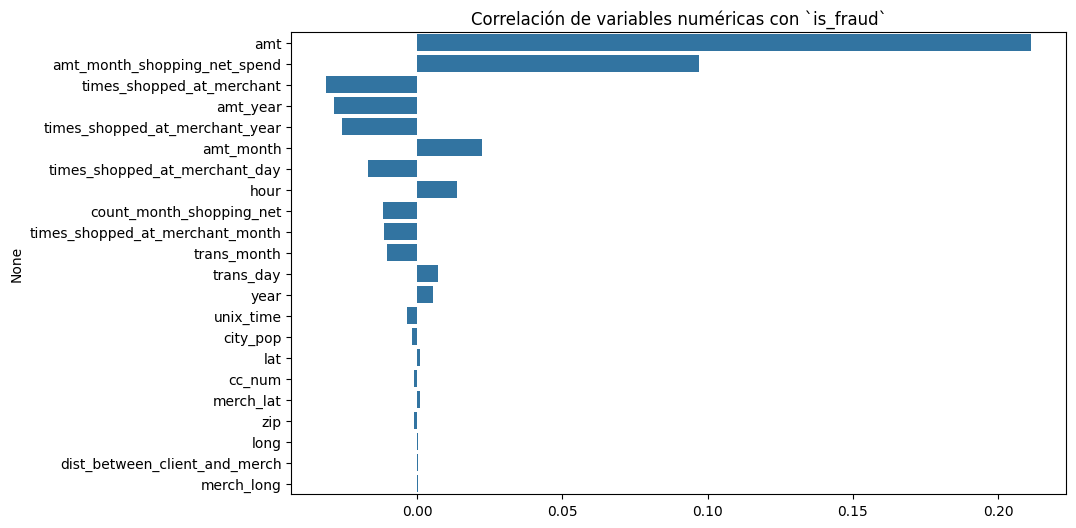

In [8]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(columns=['is_fraud'])
corr = numeric_cols.corrwith(df['is_fraud']).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlación de variables numéricas con `is_fraud`")
plt.show()


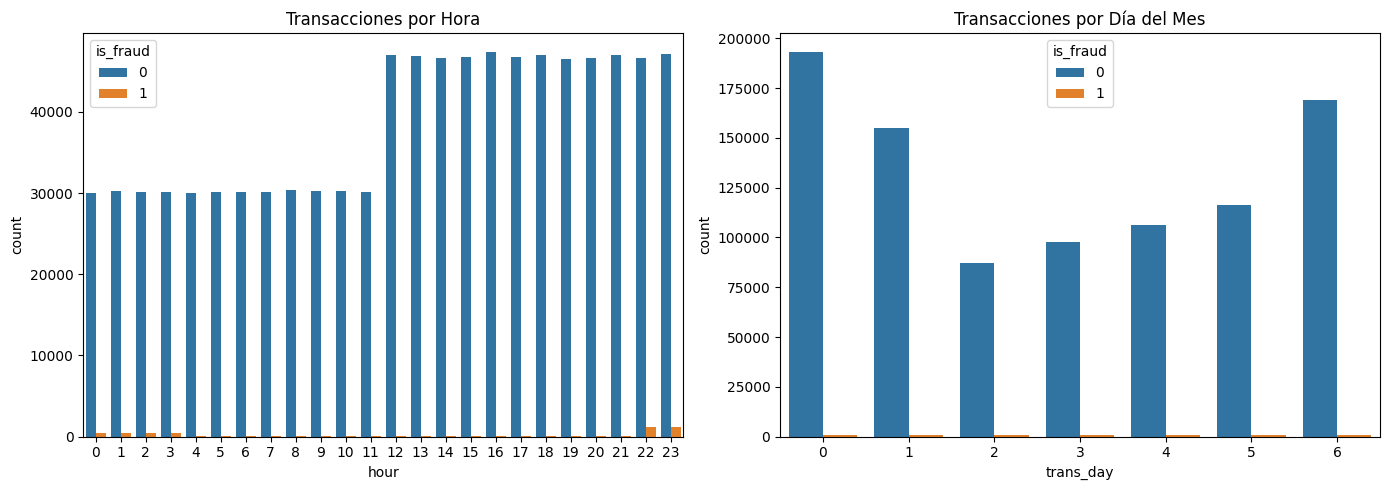

<function abs(x, /)>

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='hour', hue='is_fraud', data=df, ax=ax[0])
ax[0].set_title('Transacciones por Hora')

sns.countplot(x='trans_day', hue='is_fraud', data=df, ax=ax[1])
ax[1].set_title('Transacciones por Día del Mes')

plt.tight_layout()
plt.show()
abs

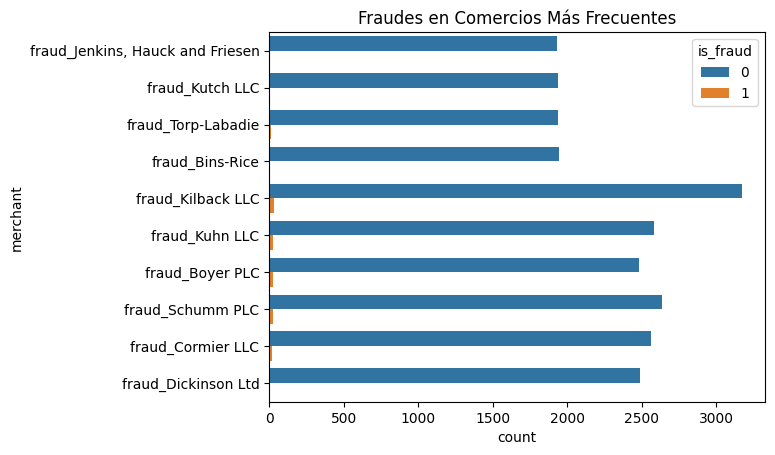

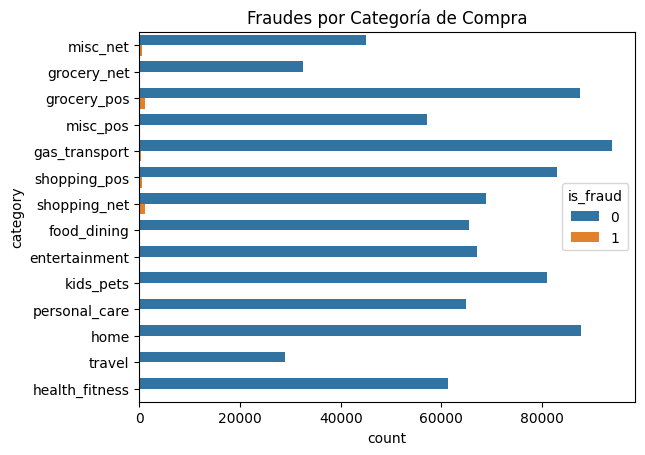

In [10]:
top_merchants = df['merchant'].value_counts().head(10).index
df_top = df[df['merchant'].isin(top_merchants)]

sns.countplot(y='merchant', hue='is_fraud', data=df_top)
plt.title("Fraudes en Comercios Más Frecuentes")
plt.show()

sns.countplot(y='category', hue='is_fraud', data=df)
plt.title("Fraudes por Categoría de Compra")
plt.show()


In [11]:
# ==============================
# VARIABLES ADICIONALES PARA COMPLEJIDAD
# ==============================
"""
    ¿Qué hace?
    Calcula la tasa histórica de fraude por cada comercio (merchant).

    ¿Para qué sirve?
    Si un comercio tiene una alta tasa de fraude, las futuras transacciones allí se pueden considerar más riesgosas.

    Ejemplo: Si “TiendaX” tiene 20% de fraudes históricos, cualquier compra ahí podría considerarse de mayor riesgo.
"""
fraud_rate_by_merchant = df.groupby("merchant")["is_fraud"].mean()
df["merchant_fraud_rate"] = df["merchant"].map(fraud_rate_by_merchant)

"""
    ¿Qué hace?
    Igual que el anterior, pero agrupando por tipo de producto o servicio (category) en lugar de comercio.

    ¿Para qué sirve?
    Algunas categorías (como “juegos online” o “compras de lujo”) tienden a estar más asociadas a fraude.

"""
fraud_rate_by_category = df.groupby("category")["is_fraud"].mean()
df["category_fraud_rate"] = df["category"].map(fraud_rate_by_category)


"""
    ¿Qué hace?
    Calcula la frecuencia relativa diaria de compras en un comercio, normalizada con respecto al mes.
    
    ¿Por qué es útil?
    Si alguien compra 4 veces en un día pero solo 4 veces en todo el mes, es extraño. Esto detecta comportamientos inusuales de repetición intensiva.
"""
df["rel_freq_at_merchant"] = df["times_shopped_at_merchant_day"] / (df["times_shopped_at_merchant_month"] + 1)

"""
    ¿Qué hace?
    Calcula el z-score del monto de la transacción comparado con el historial del mismo cliente (cc_num).
    
    ¿Para qué sirve?
    Detecta si el monto de la transacción es inusualmente alto o bajo respecto a lo que normalmente gasta ese usuario.
    
    Ejemplo: Si alguien suele gastar Q50 y de repente hace una transacción de Q1000, eso genera un z-score alto.
"""
client_mean_amt = df.groupby("cc_num")["amt"].transform("mean")
client_std_amt = df.groupby("cc_num")["amt"].transform("std")
df["zscore_amt"] = (df["amt"] - client_mean_amt) / (client_std_amt + 1e-5)


"""
    ¿Qué hace?
    Crea dos columnas:
        madrugada: indica si una transacción ocurrió entre la 0:00 y las 3:59 a.m.
        pct_madrugada: porcentaje de las transacciones del usuario que ocurren a esa hora.
    
    ¿Por qué es relevante?
    Muchos fraudes ocurren en horarios nocturnos. Pero si un cliente suele comprar de madrugada, eso no es anormal para él. Esta variable permite distinguir eso.
"""
df["madrugada"] = df["hour"].isin([0, 1, 2, 3])
df["pct_madrugada"] = df.groupby("cc_num")["madrugada"].transform("mean")


/tmp/ipykernel_21790/3988873198.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["merchant_fraud_rate"] = df["merchant"].map(fraud_rate_by_merchant)
/tmp/ipykernel_21790/3988873198.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["category_fraud_rate"] = df["category"].map(fraud_rate_by_category)
/tmp/ipykernel_21790/3988873198.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [12]:
"""
    Definicion de una regla de negocio híbrida para identificar perfiles de transacciones complejas, utilizando dos enfoques combinados:
    - CONDICIÓN 1: Gasto anual alto o anómalo
    Se cumple si el cliente está en el top 10% de gasto anual o si su gasto está muy por encima del promedio (z-score > 2).
    ¿Por qué usar ambas?
        El percentil captura extremos absolutos.
        El z-score detecta valores atípicos aunque no sean tan altos en términos absolutos, pero sí lo son para ese cliente.
    - CONDICIÓN 2: Alta fidelidad a un comercio
    Se asegura que el cliente compra muchas veces en un mismo comercio, algo que puede indicar automatismo o patrones sospechosos.
    - CONDICIÓN 3: Alta actividad en línea
    Detecta clientes con muchas compras online en el mes actual, lo cual es útil para detectar fraudes por bots o tarjetas comprometidas.
"""
from scipy.stats import zscore

# FLAG ORIGINAL DE PERFIL COMPLEJO
# regla_negocio = (
#     (df['amt_year'] > df['amt_year'].quantile(0.90)) &
#     (df['times_shopped_at_merchant_year'] > df['times_shopped_at_merchant_year'].quantile(0.90)) &
#     (df['count_month_shopping_net'] > df['count_month_shopping_net'].quantile(0.90))
# )


# MAYOR SENSIBILIDAD
# regla_negocio = (
#     (df['amt_year'] > df['amt_year'].quantile(0.80)) &
#     (df['times_shopped_at_merchant_year'] > df['times_shopped_at_merchant_year'].quantile(0.80)) &
#     (df['count_month_shopping_net'] > df['count_month_shopping_net'].quantile(0.80))
# )

"""
    ¿Qué hace?
    Calcula el z-score de amt_year, que mide cuánto se desvía el gasto anual de un cliente respecto a la media de todos.

    ¿Para qué sirve?
    Si un cliente gasta muchísimo más que el promedio (z > 2), se detecta como comportamiento atípico.
"""
df["zscore_amt_year"] = zscore(df["amt_year"].fillna(0))

"""
    ¿Qué hace?
    Encuentra el valor por encima del cual solo el 10% de los clientes más gastadores se ubican.
    
    ¿Ejemplo?
    Si el percentil 90 de amt_year es Q12,000, cualquier cliente que gastó más de eso está en el top 10% de mayor gasto.
"""
umbral_percentil = df["amt_year"].quantile(0.90)

regla_negocio = (
    ((df['amt_year'] > umbral_percentil) | (df["zscore_amt_year"] > 2)) & # Gasto anual alto o anómalo
    (df['times_shopped_at_merchant_year'] > df['times_shopped_at_merchant_year'].quantile(0.90)) & # Alta fidelidad a un comercio
    (df['count_month_shopping_net'] > df['count_month_shopping_net'].quantile(0.90)) # Alta actividad en línea
)


/tmp/ipykernel_21790/1039147835.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["zscore_amt_year"] = zscore(df["amt_year"].fillna(0))


In [13]:
# FLAG DE DISPERSIÓN
# Se  mide cuán variable es cada cliente en cuánto gasta y en qué momento del tiempo lo hace.
df["client_std_amt"] = client_std_amt
client_std_time = df.groupby("cc_num")["unix_time"].transform("std")
df["client_std_time"] = client_std_time

# Se calcula la desviación estándar global de amt y unix_time para comparar contra los clientes.
global_amt_std = df["amt"].std()
global_time_std = df["unix_time"].std()

"""
    Marca como perfil complejo a los clientes que:
        Tienen una variabilidad en gasto muy alta (más del doble del promedio global),
        y además hacen compras en momentos muy irregulares (su variación en unix_time también es el doble del global).
"""
heuristica_dispersion = (
    (df["client_std_amt"] > global_amt_std * 2) &
    (df["client_std_time"] > global_time_std * 2)
)

# PERFIL COMPLEJO FINAL. Se amplía la cobertura del modelo: detecta tanto usuarios intensivos regulares como usuarios erráticos o inesperados.
df['is_complex_profile'] = regla_negocio | heuristica_dispersion


/tmp/ipykernel_21790/1215755030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["client_std_amt"] = client_std_amt
/tmp/ipykernel_21790/1215755030.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["client_std_time"] = client_std_time
/tmp/ipykernel_21790/1215755030.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [14]:
# ==============================
# DIVISIÓN DEL DATASET
# ==============================

"""
    train_df: datos de los meses 1 a 11
    test_df: datos del mes 12 (último mes del año)
"""
# train_df = df[df['trans_month'] < 12].copy()
# test_df  = df[df['trans_month'] == 12].copy()
train_df = df[df['trans_month'] < 10].copy()  # Enero a septiembre
test_df  = df[df['trans_month'] >= 10].copy()  # Octubre a diciembre


"""
    X_*: las variables predictoras.
    y_*: la variable objetivo (is_fraud).
"""
X_train = train_df.drop(columns=['is_fraud'])
y_train = train_df['is_fraud']
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']

"""
    Si is_complex_profile es False → peso = 3
    Si True → peso = 1
"""
weights = (~X_train['is_complex_profile']).astype(int) * 2 + 1

# Esto evita pasar al modelo una variable que se usa para ajustar los pesos, pero no debe usarse como predictor directo (evita fugas de información).
X_train_model = X_train.drop(columns=['is_complex_profile'])
X_test_model = X_test.drop(columns=['is_complex_profile'])


"""
    Asegurar tipos adecuados en los sets finales.
    Esto convierte las columnas tipo object (strings) a tipo category, que LightGBM puede manejar 
    internamente de forma óptima (one-hot encoding implícito).
"""
for col in X_train_model.select_dtypes(include='object').columns:
    X_train_model[col] = X_train_model[col].astype('category')
    X_test_model[col] = X_test_model[col].astype('category')

train_set = lgb.Dataset(X_train_model, label=y_train, weight=weights)
valid_set = lgb.Dataset(X_test_model, label=y_test)


In [15]:
# ==============================
# FUNCIONES AUXILIARES Y MÉTRICAS
# ==============================

def compute_scale_pos_weight(y, cap=300):
    """
    Calcula el valor de scale_pos_weight para LightGBM en datasets desbalanceados.

    Parameters
    ----------
    y : array-like
        Vector de etiquetas (0 = legítimo, 1 = fraude).
    cap : float, optional
        Valor máximo permitido para evitar valores extremos.

    Returns
    -------
    float
        Valor de scale_pos_weight limitado por `cap`.
    """
    count_neg = np.sum(np.array(y) == 0)
    count_pos = np.sum(np.array(y) == 1)
    weight = count_neg / count_pos
    return min(weight, cap)


def custom_threshold(preds_proba, is_complex, threshold_simple=0.5, threshold_complex=0.7):
    """
    Aplica un umbral de clasificación diferenciado según la complejidad del perfil.

    Parameters
    ----------
    preds_proba : np.ndarray
        Vector de probabilidades predichas por el modelo.
    is_complex : array-like
        Vector booleano que indica si cada muestra es compleja.
    threshold_simple : float
        Umbral para perfiles simples.
    threshold_complex : float
        Umbral para perfiles complejos.

    Returns
    -------
    np.ndarray
        Predicciones binarias (0 o 1).
    """
    return np.where(
        is_complex,
        preds_proba > threshold_complex,
        preds_proba > threshold_simple
    ).astype(int)


def report_fp_complex(y_true, y_pred, is_complex):
    """
    Reporta el número de falsos positivos y su proporción en perfiles complejos.

    Parameters
    ----------
    y_true : array-like
        Etiquetas verdaderas.
    y_pred : array-like
        Predicciones binarias.
    is_complex : array-like
        Vector booleano indicando si el perfil es complejo.

    Returns
    -------
    None
    """
    false_positives = (y_true == 0) & (y_pred == 1)
    fp_complex = false_positives & is_complex
    print(f"Falsos Positivos totales: {false_positives.sum()}")
    print(f"Falsos Positivos en perfiles complejos: {fp_complex.sum()}")
    print(f"Proporción de FP complejos: {fp_complex.sum() / (false_positives.sum() + 1e-6):.4f}")


def feval_penalty_fp_complex(preds, train_data):
    """
    Función de evaluación para LightGBM: penaliza más los falsos positivos complejos.

    Parameters
    ----------
    preds : np.ndarray
        Probabilidades predichas por el modelo.
    train_data : lightgbm.Dataset
        Dataset de entrenamiento con etiquetas y pesos.

    Returns
    -------
    tuple
        Nombre de la métrica, valor calculado y bandera 'higher is better'.
    """
    labels = train_data.get_label()
    preds_binary = (preds > 0.5).astype(int)
    complexity = train_data.get_weight()
    if complexity is None:
        complexity = np.zeros_like(labels)
    tp = ((labels == 1) & (preds_binary == 1)).sum()
    fp = ((labels == 0) & (preds_binary == 1)).astype(int)
    fp_penalized = (fp * (1 + complexity)).sum()
    score = tp / (tp + fp_penalized + 1e-6)
    return 'tp_over_penalized_fp', score, True


def feval_f1_fp_penalty(preds, train_data):
    """
    Evalúa F1 penalizando los falsos positivos en perfiles complejos.

    Parameters
    ----------
    preds : np.ndarray
        Probabilidades predichas por el modelo.
    train_data : lightgbm.Dataset
        Dataset de entrenamiento.

    Returns
    -------
    tuple
        Nombre de la métrica, valor penalizado del F1, bandera 'higher is better'.
    """
    labels = train_data.get_label()
    preds_binary = (preds > 0.5).astype(int)
    complexity = train_data.get_weight()
    if complexity is None:
        complexity = np.zeros_like(labels)
    tp = ((labels == 1) & (preds_binary == 1)).sum()
    fp = ((labels == 0) & (preds_binary == 1)).sum()
    fn = ((labels == 1) & (preds_binary == 0)).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    fp_penalty = ((labels == 0) & (preds_binary == 1) & (complexity == 1)).sum()
    penalty_factor = fp_penalty / (tp + 1e-6)
    return 'f1_penalized', f1 - 0.1 * penalty_factor, True


def feval_precision_boosted(preds, train_data):
    """
    Penaliza la precisión en función de los falsos positivos complejos.

    Parameters
    ----------
    preds : np.ndarray
        Probabilidades predichas.
    train_data : lightgbm.Dataset
        Dataset de entrenamiento.

    Returns
    -------
    tuple
        Nombre de la métrica, precisión penalizada, bandera 'higher is better'.
    """
    labels = train_data.get_label()
    preds_binary = (preds > 0.5).astype(int)
    complexity = train_data.get_weight()
    if complexity is None:
        complexity = np.zeros_like(labels)
    tp = ((labels == 1) & (preds_binary == 1)).sum()
    fp = ((labels == 0) & (preds_binary == 1)).sum()
    precision = tp / (tp + fp + 1e-6)
    fp_complex = ((labels == 0) & (preds_binary == 1) & (complexity == 1)).sum()
    penalty = 0.05 * fp_complex
    return 'precision_boosted', precision - penalty / (tp + 1e-6), True


In [16]:
# ==============================
# ENTRENAMIENTO Y COMPARACIÓN FINAL
# ==============================

"""
    objective: clasificación binaria.
    metric: métrica base (auc), aunque se usan funciones de evaluación personalizadas (feval).
    scale_pos_weight: compensa el desbalance entre clases (más fraudes → más peso).
    learning_rate, num_leaves: controlan la complejidad y velocidad del modelo.
    seed: para reproducibilidad.
"""
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'scale_pos_weight': compute_scale_pos_weight(y_train),
    'seed': 42
}

# Este diccionario guardará el modelo entrenado y sus predicciones (probas, bins) por cada función de evaluación.
results = {}

def entrenar_y_evaluar(feval_fn, nombre):
    """
        Parameters
        ----------
        feval_fn : callable
            Función personalizada para evaluar el modelo durante el entrenamiento.
        nombre : str
            Nombre descriptivo de la función de evaluación (usado para impresión).
        
        Returns
        -------
        tuple
            - model : lightgbm.Booster
                Modelo entrenado.
            - preds_proba : np.ndarray
                Probabilidades predichas para el conjunto de prueba.
            - preds_bin : np.ndarray
                Predicciones binarias usando umbral diferenciado según complejidad.
    """
    print(f"\nEntrenando con métrica: {nombre}")
    model = lgb.train(
        params,
        train_set,
        valid_sets=[valid_set],
        num_boost_round=500,
        feval=feval_fn,
        callbacks=[
            lgb.early_stopping(50),
            lgb.log_evaluation(50)
        ]
    )
    preds_proba = model.predict(X_test_model)
    preds_bin = custom_threshold(preds_proba, X_test['is_complex_profile'])
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_test, preds_bin))
    print("\nClassification Report:")
    print(classification_report(y_test, preds_bin, digits=4))
    report_fp_complex(y_test.values, preds_bin, X_test['is_complex_profile'].values)
    return model, preds_proba, preds_bin

"""
    Recorre cada métrica personalizada (feval_fn) y su nombre (name).
    Llama a entrenar_y_evaluar y guarda los resultados en el diccionario results.
"""
for name, feval_fn in [
    ("penalty_fp_complex", feval_penalty_fp_complex),
    ("f1_fp_penalty", feval_f1_fp_penalty),
    ("precision_boosted", feval_precision_boosted),
]:
    model, probas, bins = entrenar_y_evaluar(feval_fn, name)
    results[name] = {
        "model": model,
        "preds_bin": bins,
        "preds_proba": probas
    }



Entrenando con métrica: penalty_fp_complex
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3495, number of negative: 642528
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9522
[LightGBM] [Info] Number of data points in the train set: 646023, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005416 -> initscore=-5.212931
[LightGBM] [Info] Start training from score -5.212931
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.966341	valid_0's tp_over_penalized_fp: 0.295771
Early stopping, best iteration is:


In [17]:
# ==============================
# SELECCIÓN FINAL Y REPORTE
# ==============================

best_key = max(
    results,
    key=lambda k: classification_report(y_test, results[k]['preds_bin'], output_dict=True)['1']['f1-score']
)
print(f"\nMejor métrica: {best_key}")
# Se extraen las predicciones binarias (0 o 1) del modelo ganador, para realizar un análisis más detallado.
y_pred_bin = results[best_key]['preds_bin']
# Se recupera el vector booleano que indica si cada transacción en el conjunto de prueba tiene un perfil complejo.
is_complex = X_test['is_complex_profile']
# Se construye un boolean array que indica dónde ocurrieron falsos positivos: es decir, el modelo predijo fraude (1), pero la etiqueta verdadera era legítima (0).
false_positives = (y_test == 0) & (y_pred_bin == 1)
print(f"FP complejos: {false_positives[is_complex].sum()} / {false_positives.sum()}")


Mejor métrica: penalty_fp_complex
FP complejos: 19 / 2858


Se desarrolló un modelo de detección de fraude con LightGBM, mejorado con:

    Variables nuevas que capturan patrones de riesgo.

    Una lógica híbrida para definir “perfiles complejos”.

    Funciones de evaluación personalizadas que penalizan falsos positivos dependiendo del contexto.

In [18]:
# ==============================
# MODELO BASE: LightGBM SIN VARIABLES EXTRA
# ==============================

baseline_features = [
    'amt', 'hour', 'trans_day', 'trans_month',
    'amt_year', 'count_month_shopping_net',
    'times_shopped_at_merchant_year',
    'times_shopped_at_merchant_month',
    'times_shopped_at_merchant_day'
]

X_train_base = X_train[baseline_features]
X_test_base = X_test[baseline_features]

train_base = lgb.Dataset(X_train_base, label=y_train)
valid_base = lgb.Dataset(X_test_base, label=y_test)

params_base = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'scale_pos_weight': compute_scale_pos_weight(y_train),
    'seed': 42
}

model_base = lgb.train(
    params_base,
    train_base,
    valid_sets=[valid_base],
    num_boost_round=300,
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(50)
    ]
)

preds_base = model_base.predict(X_test_base)
y_pred_base = (preds_base > 0.5).astype(int)

print("=== Modelo Base ===")
print(confusion_matrix(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base, digits=4))


[LightGBM] [Info] Number of positive: 3495, number of negative: 642528
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 646023, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005410 -> initscore=-5.214077
[LightGBM] [Info] Start training from score -5.214077
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.976879
Early stopping, best iteration is:
[6]	valid_0's auc: 0.978864
=== Modelo Base ===
[[265484  16289]
 [    89   1181]]
              precision    recall  f1-score   support

           0     0.9997    0.9422    0.9701    281773
           1     0.0676    0.9299    0.1260      1270

    accuracy                         0.9421    283043
   macro avg     

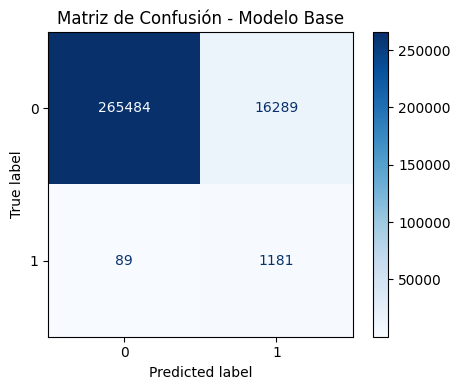

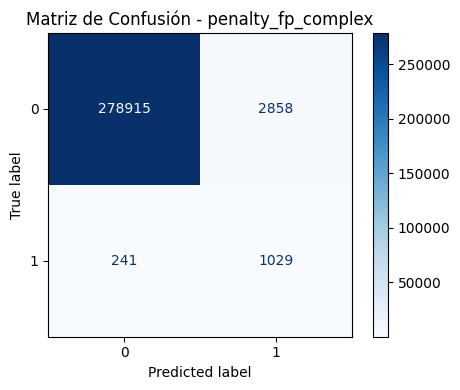

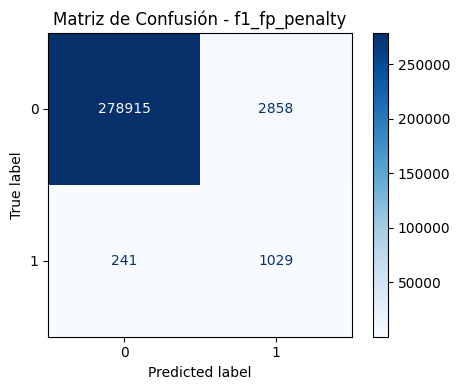

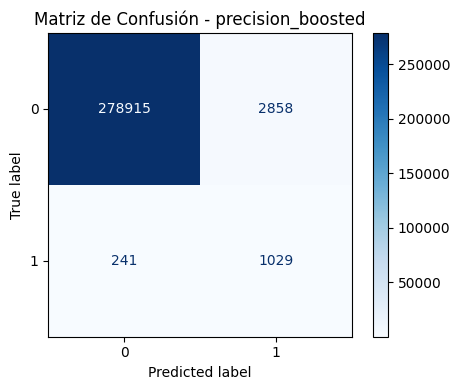

,Modelo,Precision (Fraude),Recall (Fraude),F1-Score (Fraude),Accuracy
0,Modelo Base,0.067602,0.929921,0.126041,0.942136
1,penalty_fp_complex,0.264729,0.810236,0.399069,0.989051
2,f1_fp_penalty,0.264729,0.810236,0.399069,0.989051
3,precision_boosted,0.264729,0.810236,0.399069,0.989051


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import pandas as pd

# Lista de nombres de los modelos
model_names = ['Modelo Base', 'penalty_fp_complex', 'f1_fp_penalty', 'precision_boosted']

# Diccionario con predicciones binarias de cada modelo
predictions = {
    'Modelo Base': y_pred_base,
    'penalty_fp_complex': results['penalty_fp_complex']['preds_bin'],
    'f1_fp_penalty': results['f1_fp_penalty']['preds_bin'],
    'precision_boosted': results['precision_boosted']['preds_bin'],
}

# === Matriz de Confusión ===
for name in model_names:
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, predictions[name], ax=ax, cmap="Blues")
    ax.set_title(f"Matriz de Confusión - {name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# === Métricas por modelo (Precision, Recall, F1, Accuracy) ===
metrics_summary = []
for name in model_names:
    report = classification_report(y_test, predictions[name], output_dict=True)
    metrics_summary.append({
        'Modelo': name,
        'Precision (Fraude)': report['1']['precision'],
        'Recall (Fraude)': report['1']['recall'],
        'F1-Score (Fraude)': report['1']['f1-score'],
        'Accuracy': report['accuracy']
    })

df_metrics = pd.DataFrame(metrics_summary)
display(df_metrics)  # Para notebooks Jupyter estándar

# Si usas entorno con ace_tools (como algunos entornos evaluados):
# import ace_tools as tools; tools.display_dataframe_to_user(name="Resumen de Métricas por Modelo", dataframe=df_metrics)


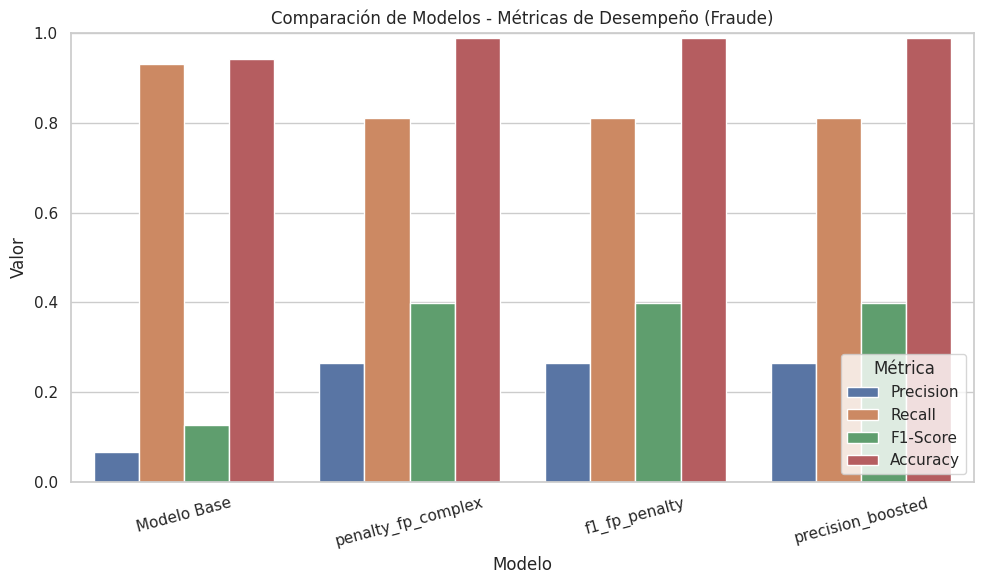


Resumen de Métricas por Modelo:
               Modelo  Precision  Recall  F1-Score  Accuracy
0         Modelo Base     0.0676  0.9299    0.1260    0.9421
1  penalty_fp_complex     0.2647  0.8102    0.3991    0.9891
2       f1_fp_penalty     0.2647  0.8102    0.3991    0.9891
3   precision_boosted     0.2647  0.8102    0.3991    0.9891


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# Preparar predicciones
model_names = ['Modelo Base', 'penalty_fp_complex', 'f1_fp_penalty', 'precision_boosted']
predictions = {
    'Modelo Base': y_pred_base,
    'penalty_fp_complex': results['penalty_fp_complex']['preds_bin'],
    'f1_fp_penalty': results['f1_fp_penalty']['preds_bin'],
    'precision_boosted': results['precision_boosted']['preds_bin'],
}

# Crear resumen de métricas
metrics_summary = []
for name in model_names:
    report = classification_report(y_test, predictions[name], output_dict=True)
    metrics_summary.append({
        'Modelo': name,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'Accuracy': report['accuracy']
    })

df_metrics = pd.DataFrame(metrics_summary)

# Reorganizar para gráfico con seaborn
df_plot = df_metrics.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

# Estilo visual
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="Modelo", y="Valor", hue="Métrica")

plt.title("Comparación de Modelos - Métricas de Desempeño (Fraude)")
plt.ylim(0, 1)
plt.ylabel("Valor")
plt.xticks(rotation=15)
plt.legend(title="Métrica", loc="lower right")
plt.tight_layout()
plt.show()

# Mostrar resumen de métricas
print("\nResumen de Métricas por Modelo:")
print(df_metrics.round(4))


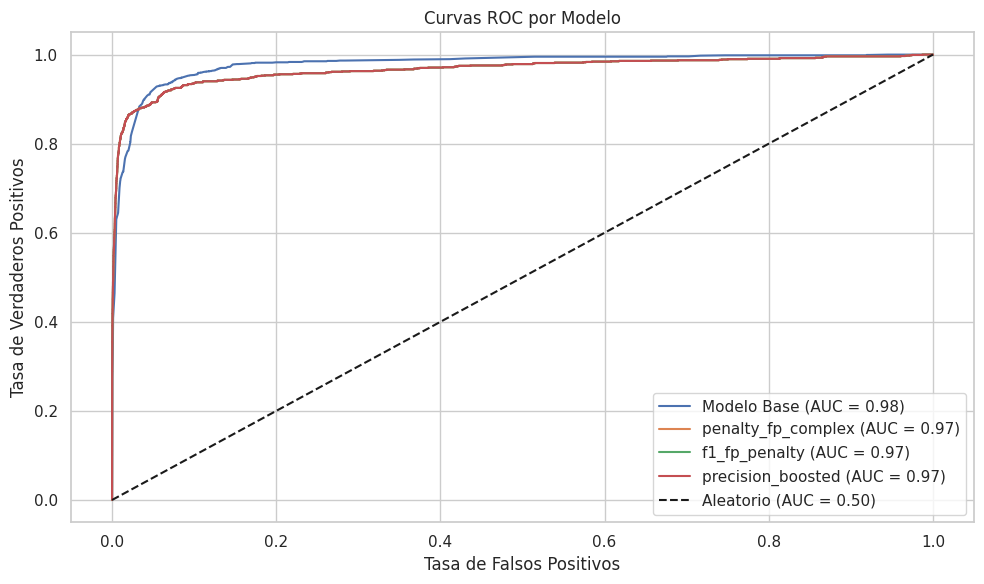

In [21]:
# Suponiendo que ya has entrenado el modelo_base y tienes los resultados anteriores

# Calcular predicciones de probabilidad para el modelo base
preds_proba_base = model_base.predict(X_test_base)

# Diccionario con todos los resultados
predictions_proba = {
    'Modelo Base': preds_proba_base,
    'penalty_fp_complex': results['penalty_fp_complex']['preds_proba'],
    'f1_fp_penalty': results['f1_fp_penalty']['preds_proba'],
    'precision_boosted': results['precision_boosted']['preds_proba'],
}

# Graficar curvas ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, proba in predictions_proba.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Modelo')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

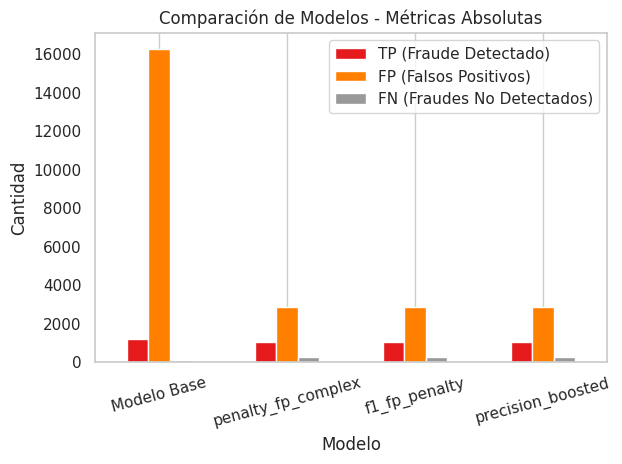

,Modelo,TP (Fraude Detectado),FP (Falsos Positivos),FN (Fraudes No Detectados),TN
0,Modelo Base,1181,16289,89,265484
1,penalty_fp_complex,1029,2858,241,278915
2,f1_fp_penalty,1029,2858,241,278915
3,precision_boosted,1029,2858,241,278915


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

# Asegúrate de tener estas variables ya definidas:
# - y_pred_base: predicciones binarias del modelo base
# - y_test: etiquetas verdaderas del conjunto de prueba
# - results: diccionario con las predicciones de los modelos personalizados

# Preparar predicciones
model_names = ['Modelo Base', 'penalty_fp_complex', 'f1_fp_penalty', 'precision_boosted']
predictions = {
    'Modelo Base': y_pred_base,
    'penalty_fp_complex': results['penalty_fp_complex']['preds_bin'],
    'f1_fp_penalty': results['f1_fp_penalty']['preds_bin'],
    'precision_boosted': results['precision_boosted']['preds_bin'],
}

# Crear resumen de métricas con valores absolutos
metrics_summary = []
for name in model_names:
    y_pred = predictions[name]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    metrics_summary.append({
        'Modelo': name,
        'TP (Fraude Detectado)': tp,
        'FP (Falsos Positivos)': fp,
        'FN (Fraudes No Detectados)': fn,
        'TN': tn
    })

df_counts = pd.DataFrame(metrics_summary)

# Graficar
df_plot = df_counts.set_index('Modelo')[['TP (Fraude Detectado)', 'FP (Falsos Positivos)', 'FN (Fraudes No Detectados)']]
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
df_plot.plot(kind='bar', stacked=False, colormap='Set1')
plt.title('Comparación de Modelos - Métricas Absolutas')
plt.ylabel('Cantidad')
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Mostrar resumen
df_counts
